![title](https://meterpreter.org/wp-content/uploads/2017/12/pytorch-logo-dark-1024x205.png)

In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
from torch import nn

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available else 'cpu'
print('selected device:', device)

selected device: cuda


In [22]:
# Creating sample data
weight = 0.7 # weight = m
bias = 0.3 # bias = c

start = 0
stop = 1
steps = 0.01

# Create X and y (features and labels)
X = torch.arange(start, stop, steps).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

In [23]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [24]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

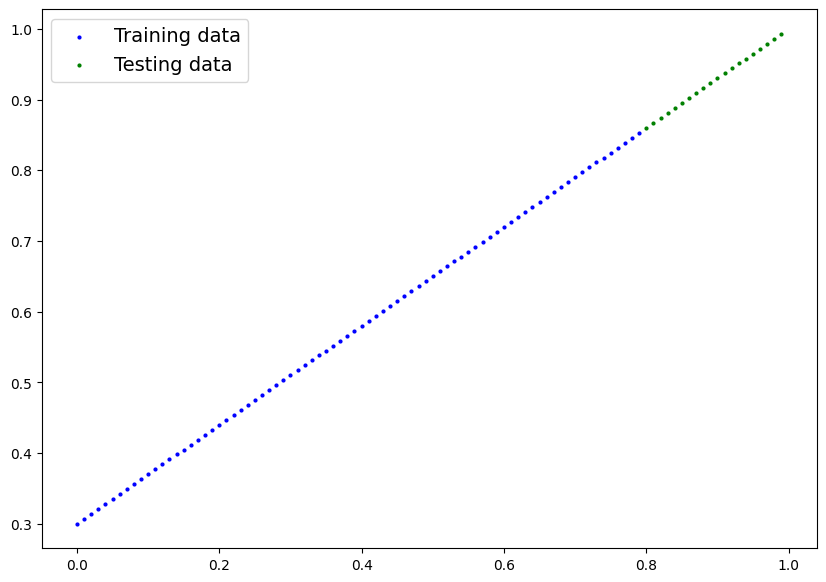

In [25]:
plot_predictions()

In [26]:
# Building pytorch linear model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.linear_layer(x)

In [27]:
model = LinearRegressionModel()

In [28]:
model, model.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.3805]])),
              ('linear_layer.bias', tensor([0.2354]))]))

In [29]:
next(model.parameters()).device

device(type='cpu')

In [30]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [31]:
# Training
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [32]:
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


In [33]:

# Set the number of epochs 
epochs = 4000 

# Put data on the available device

for epoch in range(epochs):
    ### Training
    model.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.4914136826992035 | Test loss: 0.8962893486022949
Epoch: 100 | Train loss: 0.09864677488803864 | Test loss: 0.00327301025390625
Epoch: 200 | Train loss: 0.09864677488803864 | Test loss: 0.00327301025390625
Epoch: 300 | Train loss: 0.09864677488803864 | Test loss: 0.00327301025390625
Epoch: 400 | Train loss: 0.09864677488803864 | Test loss: 0.00327301025390625
Epoch: 500 | Train loss: 0.09864677488803864 | Test loss: 0.00327301025390625
Epoch: 600 | Train loss: 0.09864677488803864 | Test loss: 0.00327301025390625
Epoch: 700 | Train loss: 0.09864677488803864 | Test loss: 0.00327301025390625
Epoch: 800 | Train loss: 0.09864677488803864 | Test loss: 0.00327301025390625
Epoch: 900 | Train loss: 0.09864677488803864 | Test loss: 0.00327301025390625
Epoch: 1000 | Train loss: 0.09864677488803864 | Test loss: 0.00327301025390625
Epoch: 1100 | Train loss: 0.09864677488803864 | Test loss: 0.00327301025390625
Epoch: 1200 | Train loss: 0.09864677488803864 | Test loss: 0.00327

In [34]:
# Making Predictions
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)
y_preds

tensor([[0.7290],
        [0.7352],
        [0.7414],
        [0.7476],
        [0.7539],
        [0.7601],
        [0.7663],
        [0.7725],
        [0.7787],
        [0.7849],
        [0.7911],
        [0.7973],
        [0.8035],
        [0.8097],
        [0.8159],
        [0.8221],
        [0.8283],
        [0.8345],
        [0.8407],
        [0.8469]], device='cuda:0')

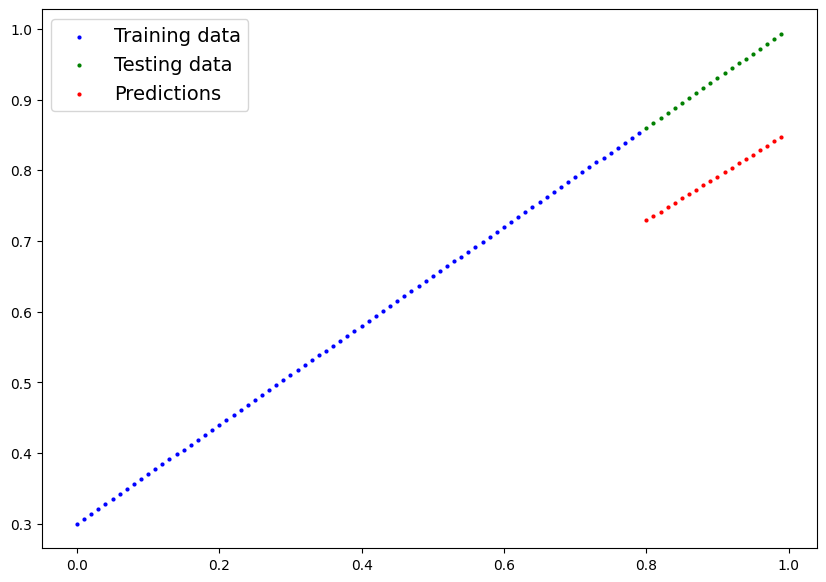

In [35]:
plot_predictions(predictions=y_preds.cpu())

In [36]:
# Save model
MODEL_PATH = Path('Model')
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = 'model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(MODEL_SAVE_PATH)
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Model\model_1.pth


In [38]:
# Load Model
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model.to(device)
print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [39]:
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

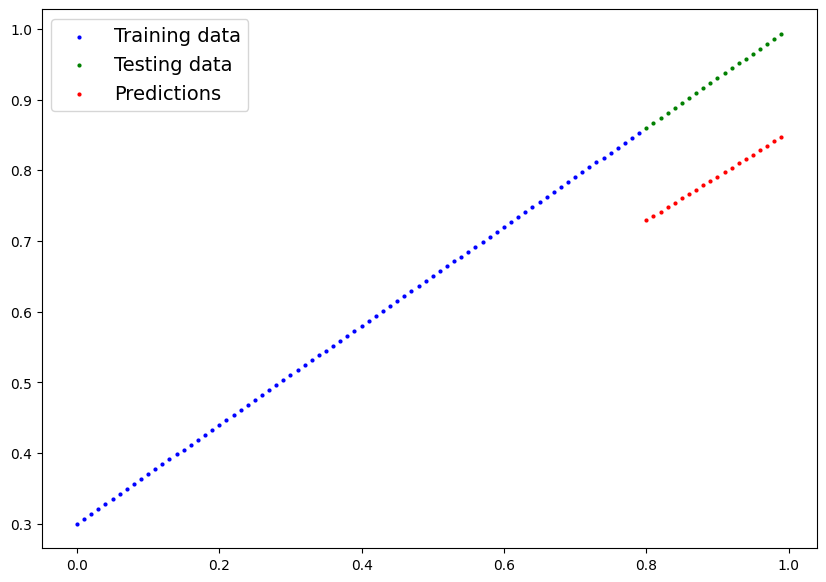

In [40]:
plot_predictions(predictions=loaded_model_preds.cpu())